# **Data preparation**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rtatman/speech-accent-archive")



100%|██████████| 865M/865M [00:15<00:00, 57.5MB/s]

Extracting files...


In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rtatman/speech-accent-archive/versions/2


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv(path + "/speakers_all.csv")
df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2172 non-null   float64
 1   age_onset        2172 non-null   float64
 2   birthplace       2168 non-null   object 
 3   filename         2172 non-null   object 
 4   native_language  2172 non-null   object 
 5   sex              2172 non-null   object 
 6   speakerid        2172 non-null   int64  
 7   country          2167 non-null   object 
 8   file_missing?    2172 non-null   bool   
 9   Unnamed: 9       0 non-null      float64
 10  Unnamed: 10      0 non-null      float64
 11  Unnamed: 11      1 non-null      object 
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 188.9+ KB


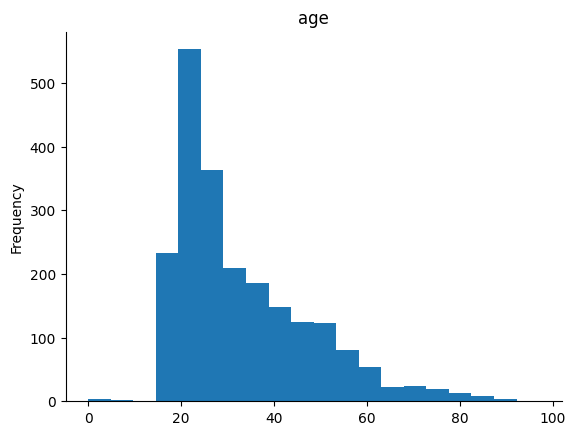

In [ ]:
df['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
unique_native_languages_count = df['native_language'].nunique()
print(f"Number of unique native languages: {unique_native_languages_count}")

Number of unique native languages: 214


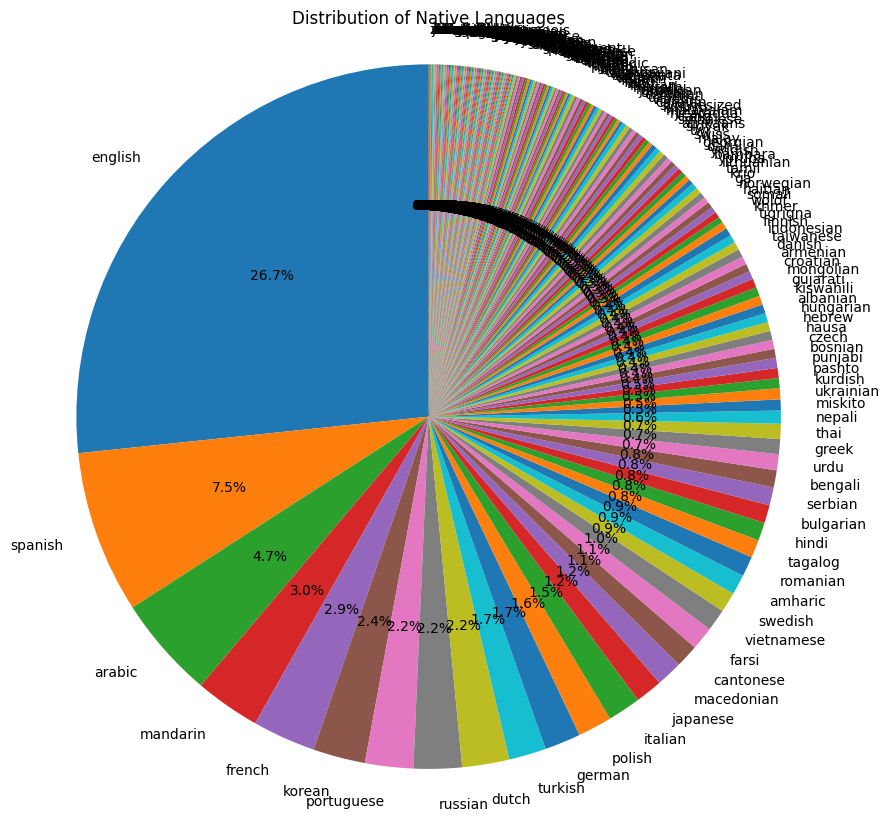

In [ ]:
native_language_counts = df['native_language'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(native_language_counts, labels=native_language_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Native Languages')
plt.axis('equal')
plt.show()

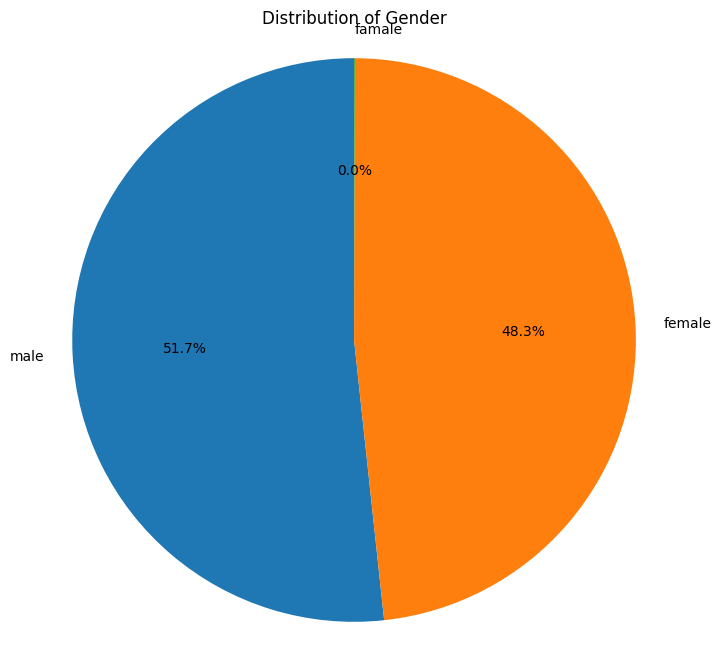

In [ ]:
gender_counts = df['sex'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Gender')
plt.axis('equal')
plt.show()

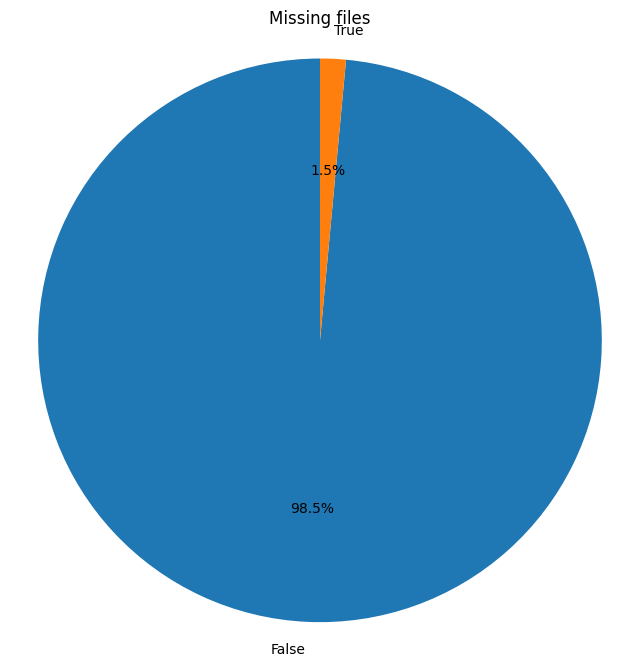

In [ ]:
file_missing = df['file_missing?'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(file_missing, labels=file_missing.index, autopct='%1.1f%%', startangle=90)
plt.title('Missing files')
plt.axis('equal')
plt.show()

In [ ]:
df = df[df['file_missing?'] != True]

In [ ]:
df.shape

(2140, 12)

In [ ]:
languages = ["spanish", "arabic", "mandarin", "french", "korean", "russian", "portuguese", "turkish", "dutch", "german", "polish", 'italian']
df = df[df['native_language'].isin(languages)]

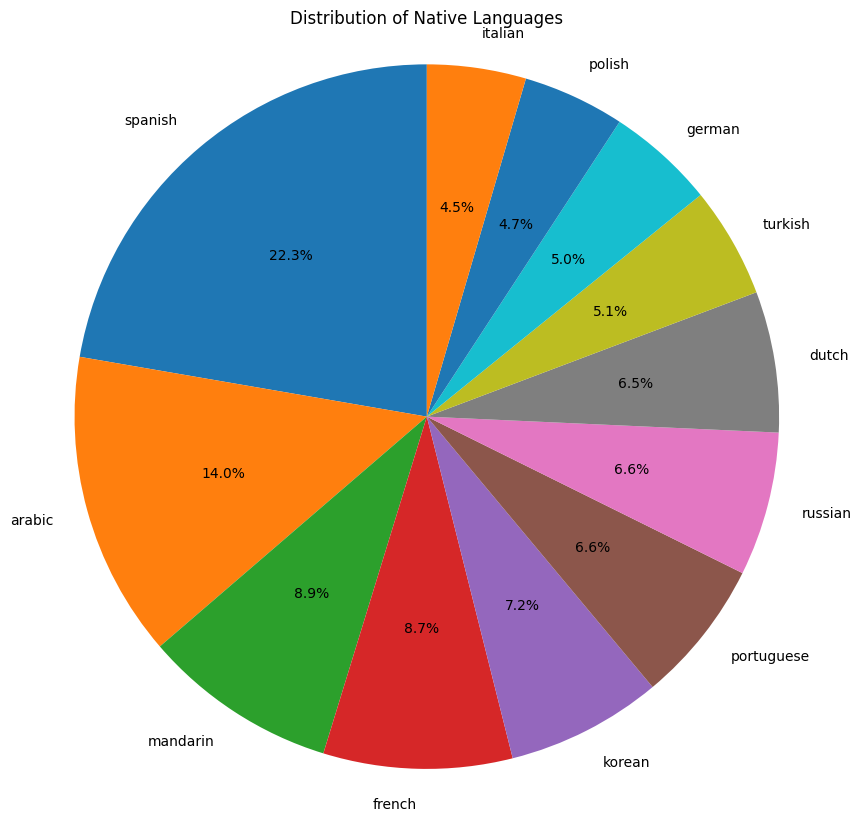

In [ ]:
native_language_counts = df['native_language'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(native_language_counts, labels=native_language_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Native Languages')
plt.axis('equal')
plt.show()

# **1. Method: Random Forest (in Spark)**

In [ ]:
df["filename"] = df["filename"].astype(str) + ".mp3"
df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
70,38.0,12.0,"riyadh, saudi arabia",arabic1.mp3,arabic,female,11,saudi arabia,False,NaN,NaN,NaN
71,26.0,5.0,"cairo, egypt",arabic10.mp3,arabic,male,12,egypt,False,NaN,NaN,NaN
72,40.0,10.0,"beirut, lebanon",arabic100.mp3,arabic,female,2159,lebanon,False,NaN,NaN,NaN
73,21.0,10.0,"doha, qatar",arabic101.mp3,arabic,male,2160,qatar,False,NaN,NaN,NaN
74,22.0,3.0,"jiddah, saudi arabia",arabic102.mp3,arabic,male,2161,saudi arabia,False,NaN,NaN,NaN


In [ ]:
df.shape

(727, 12)

### Feature extraction

Features in cour model are the Mel-frequency cepstrum coefficients:
https://en.wikipedia.org/wiki/Mel-frequency_cepstrum


*MFCCs are commonly derived as follows:[2][3]:
1. Take the Fourier transform of (a windowed excerpt of) a signal.
2. Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows or alternatively, cosine overlapping windows.
3. Take the logs of the powers at each of the mel frequencies.
4. Take the discrete cosine transform of the list of mel log powers, as if it were a signal.*

In [ ]:
import librosa
import librosa.display
import os
import re
from scipy.signal import find_peaks

audio_dir = os.path.join(path, 'recordings/recordings')
no_coeff = 150

def detect_syllables(file_path):
    # Load audio
    y, sr = librosa.load(file_path)

    # Compute the energy envelope (RMS)
    frame_length = 2048
    hop_length = 512
    energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]

    # Smooth the energy using a moving average
    smoothed_energy = np.convolve(energy, np.ones(5) / 5, mode='same')

    # Time vector for plotting
    times = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)

    # Find peaks in the energy contour
    peaks, _ = find_peaks(smoothed_energy, height=np.mean(smoothed_energy), distance=20)
    return times[peaks]

def extract_features(file_path):
    """
    Extract MFCCs, Delta MFCCs, and Chroma features from an audio file.
    """
    try:
        y, sr = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=no_coeff)
        delta_mfccs = librosa.feature.delta(mfccs)
        mfccarray=[]
        delta_arr=[]
        # total_arr=[]
        for i,coefficient in enumerate(mfccs):
          mfccarray.append(np.mean(coefficient))
          delta_arr.append(np.mean(delta_mfccs[i]))
          # total_arr.append(np.vstack([np.mean(coefficient),np.mean(delta_mfccs[i])]))

        # delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        # chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features = np.array(mfccarray)


        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


all_features = []
all_labels = []

for index, row in df.iterrows():
    file_name = row['filename']
    file_path = os.path.join(audio_dir, file_name)

    label = file_name.split('1')[0] if '1' in file_name else file_name.split('.')[0].rstrip('0123456789')

    if os.path.exists(file_path):
        features = extract_features(file_path)
        if features is not None:
            all_features.append(features)
            all_labels.append(label)
    else:
        print(f"File not found: {file_path}")


In [ ]:
import re

all_labels = [re.sub(r'\d+', '', label) for label in all_labels]

print(f'All labels: {all_labels}')


All labels: ['arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic', 'arabic

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [ ]:
spark = SparkSession.builder \
    .appName("AccentClassification") \
    .getOrCreate()

### Resampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler


X = np.array(all_features)
y = np.array(all_labels)

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

y_resampled = y_resampled.astype(str).tolist()


data_resampled = [(Vectors.dense(X_resampled[i]), y_resampled[i]) for i in range(len(y_resampled))]
df_spark = spark.createDataFrame(data_resampled, ["features", "label"])

indexer = StringIndexer(inputCol="label", outputCol="labelIndex")
df_spark = indexer.fit(df_spark).transform(df_spark)

df_spark.printSchema()
df_spark.show(5)




root
 |-- features: vector (nullable = true)
 |-- label: string (nullable = true)
 |-- labelIndex: double (nullable = false)

+--------------------+------+----------+
|            features| label|labelIndex|
+--------------------+------+----------+
|[-240.63517761230...|arabic|       0.0|
|[-334.01159667968...|arabic|       0.0|
|[-318.12744140625...|arabic|       0.0|
|[-313.7587890625,...|arabic|       0.0|
|[-245.87925720214...|arabic|       0.0|
+--------------------+------+----------+
only showing top 5 rows



### Training

In [ ]:
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestClassifier(featuresCol="features", labelCol="labelIndex")
pipeline = Pipeline(stages=[rf])
pipeline_model = pipeline.fit(train_data)

### Obtaining predictions and evaluating performance

In [ ]:
predictions = pipeline_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy*100}")

Test Accuracy: 64.53488372093024


15
15


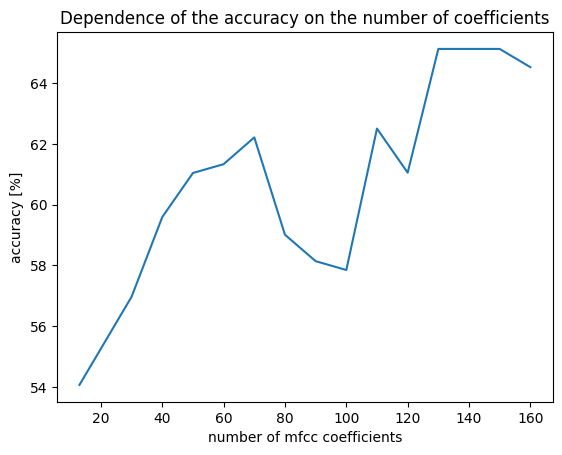

In [ ]:
x=[13,30,40,50,60,70,80,90,100,110,120,130,140,150,160]
y = [54.07,56.97, 59.59,61.04,61.33,62.21,59.01,58.14,57.85,62.5,61.05,65.12,65.12,65.12,64.52]
print(len(x))
print(len(y))
fig_logscale = plt.figure()
ax=fig_logscale.add_subplot(111)
ax.plot(x, y)
ax.set_title('Dependence of the accuracy on the number of coefficients')
ax.set_xlabel('number of mfcc coefficients')
ax.set_ylabel('accuracy [%]')
plt.show()

In [ ]:
print(audio_dir)

/root/.cache/kagglehub/datasets/rtatman/speech-accent-archive/versions/2/recordings/recordings


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


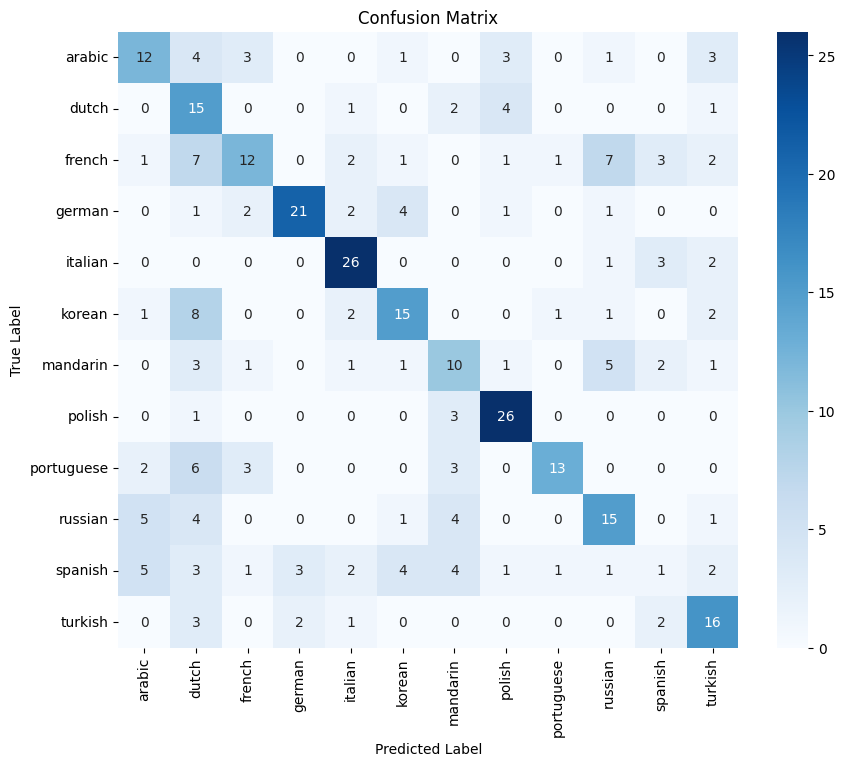

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.select("prediction", "labelIndex").rdd

metrics = MulticlassMetrics(predictionAndLabels)
confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **2. Method: Perceptron (in Spark)**

In [ ]:
spark = SparkSession.builder \
    .appName("AccentClassification") \
    .getOrCreate()

In [ ]:
data = [(Vectors.dense(all_features[i]), all_labels[i]) for i in range(len(all_labels))]
df_spark = spark.createDataFrame(data, ["features", "label"])
print(df_spark)

X = np.array(all_features)
all_labels = [re.sub(r'\d+', '', label) for label in all_labels]
y = np.array(all_labels)

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

y_resampled = y_resampled.astype(str).tolist()

data_resampled = [(Vectors.dense(X_resampled[i]), y_resampled[i]) for i in range(len(y_resampled))]
df_spark = spark.createDataFrame(data_resampled, ["features", "label"])

indexer = StringIndexer(inputCol="label", outputCol="labelIndex")

df_spark = indexer.fit(df_spark).transform(df_spark)
df_spark.show(5)

DataFrame[features: vector, label: string]
+--------------------+------+----------+
|            features| label|labelIndex|
+--------------------+------+----------+
|[-240.63517761230...|arabic|       0.0|
|[-334.01159667968...|arabic|       0.0|
|[-318.12744140625...|arabic|       0.0|
|[-313.7587890625,...|arabic|       0.0|
|[-245.87925720214...|arabic|       0.0|
+--------------------+------+----------+
only showing top 5 rows



In [ ]:
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

In [ ]:
num_features_train = train_data.select("features").first()["features"].size
print(f"Number of features in train_data: {num_features_train}")

Number of features in train_data: 128


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
layers = [128, 100,100, 50,50, 12]

mlp = MultilayerPerceptronClassifier(featuresCol="features", labelCol="labelIndex", layers = layers)
pipeline = Pipeline(stages=[mlp])
pipeline_model = pipeline.fit(train_data)

In [ ]:
predictions = pipeline_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.20348837209302326


In [ ]:
predictionAndLabels = predictions.select("prediction", "labelIndex").rdd

metrics = MulticlassMetrics(predictionAndLabels)
confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'MulticlassMetrics' is not defined

# **3. Method: CNN**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_encoded = label_encoder.transform(y_train)  # Use LabelEncoder's transform method
y_test_encoded = label_encoder.transform(y_test)
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

### Building the net (simplest)

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Build the CNN model
model = Sequential()

# First convolutional layer with normalization
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))


# Global Average Pooling layer to reduce overfitting and make the model more robust
model.add(GlobalAveragePooling1D())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Optimizer with adjusted learning rate (lower rate for stability)
optimizer = Adam(learning_rate=0.0005)  # Adjusted learning rate

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Learning rate scheduler to reduce learning rate as training progresses
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        lr = lr * 0.7  # Reduce learning rate by 30% every 10 epochs
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping, lr_scheduler])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 126, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 61, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,788 (171.05 KB)

 Trainable params: 43,404 (169.55 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1158 - loss: 2.5097 - val_accuracy: 0.0771 - val_loss: 2.4775 - learning_rate: 5.0000e-04
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1627 - loss: 2.4018 - val_accuracy: 0.1183 - val_loss: 2.4552 - learning_rate: 5.0000e-04
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2093 - loss: 2.3491 - val_accuracy: 0.2031 - val_loss: 2.4342 - learning_rate: 5.0000e-04
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2187 - loss: 2.3219 - val_accuracy: 0.2108 - val_loss: 2.4143 - learning_rate: 5.0000e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2289 - loss: 2.2594 - val_accuracy: 0.1979 - val_loss: 2.3911 - learning_rate: 5.0000e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2746 - loss: 2.2255 - val_accuracy: 0.2339 - val_loss: 2.3501 - learning_rate: 5.0000e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6923 - loss: 1.1883
Test Loss: 1.2191247940063477
Test Accuracy: 0.6760925650596619


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Predicted Accuracy: 0.6760925449871465


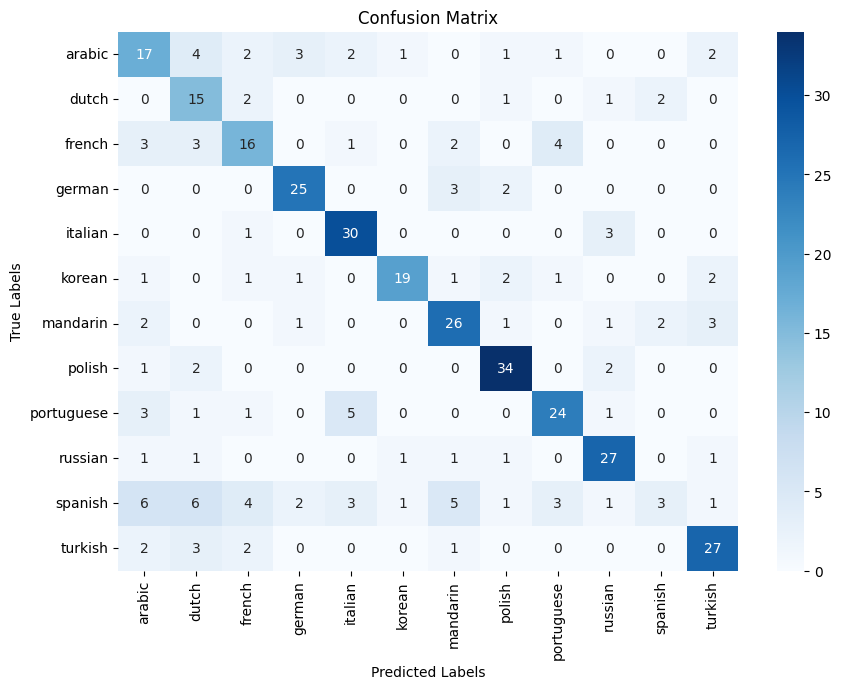

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)



y_test_int = label_encoder.transform(y_test)

accuracy_pred = accuracy_score(y_test_int, y_pred)
print(f"Predicted Accuracy: {accuracy_pred}")

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### With decreasing learning rate (a bit better):



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Hyperparameter tuning & Model improvements
model = Sequential()

# First convolutional layer with normalization
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Global Average Pooling layer to reduce overfitting and make the model more robust
model.add(GlobalAveragePooling1D())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Optimizer with adjusted learning rate (lower rate for stability)
optimizer = Adam(learning_rate=0.0005)  # Adjusted learning rate

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Learning rate scheduler to reduce learning rate as training progresses
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        lr = lr * 0.7  # Reduce learning rate by 30% every 10 epochs
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping, lr_scheduler])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 126, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 126, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 61, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 61, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,788 (171.05 KB)

 Trainable params: 43,404 (169.55 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.0981 - loss: 2.5282 - val_accuracy: 0.1028 - val_loss: 2.4828 - learning_rate: 5.0000e-04
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.1473 - loss: 2.4220 - val_accuracy: 0.1362 - val_loss: 2.4600 - learning_rate: 5.0000e-04
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1744 - loss: 2.3746 - val_accuracy: 0.1722 - val_loss: 2.4348 - learning_rate: 5.0000e-04
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.2167 - loss: 2.3137 - val_accuracy: 0.1928 - val_loss: 2.4098 - learning_rate: 5.0000e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2290 - loss: 2.2863 - val_accuracy: 0.2159 - val_loss: 2.3814 - learning_rate: 5.0000e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2577 - loss: 2.2431 - val_accuracy: 0.2442 - val_loss: 2.3433 - learning_rate: 5.0000e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6776 - loss: 1.1292
Test Loss: 1.136659860610962
Test Accuracy: 0.673521876335144


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted Accuracy: 0.712082262210797


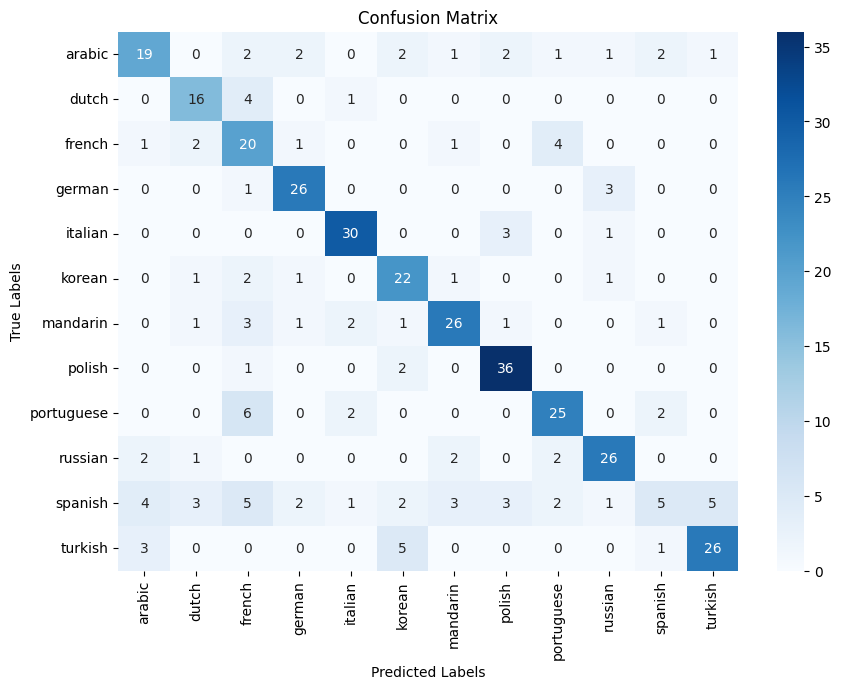

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test_int = label_encoder.transform(y_test)


accuracy_pred = accuracy_score(y_test_int, y_pred)
print(f"Predicted Accuracy: {accuracy_pred}")

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
model.save('cnn_better.h5')

# **4. Using Spark Streaming**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import VectorUDT
spark = SparkSession.builder.master('local').appName('Streaming').config('spark.ui.port', '4050').getOrCreate()

In [ ]:
from pyspark.sql.types import *
schema = StructType([
StructField('features', VectorUDT(),True),
StructField('label', StringType(), True),
StructField('labelIndex', DoubleType(), True),
])

spark_df = spark.readStream.format(“csv”).schema(schema).option(“header”, True).load(“streaming”)

# **Obtaining MCCF coefficients**

## 1. Obtaining FFT

<ipython-input-14-e38956bae5ca>:21: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(windowed_fft)


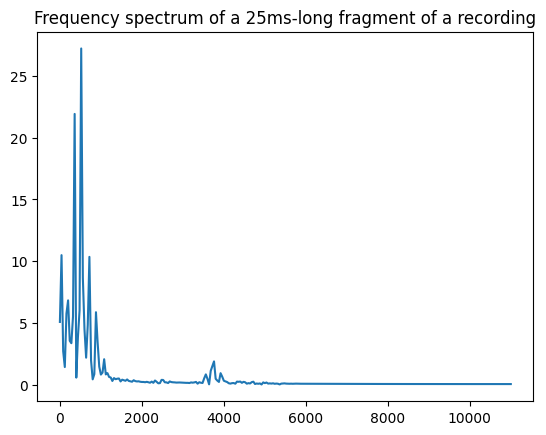

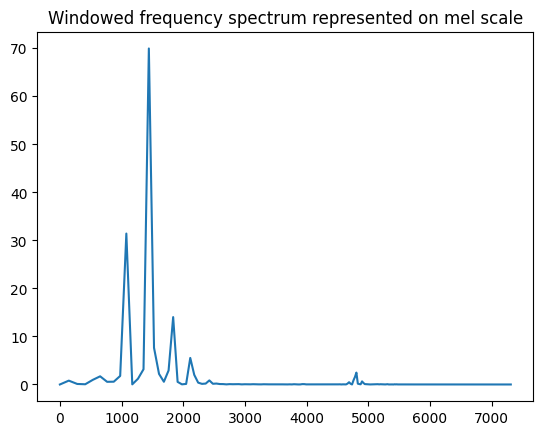

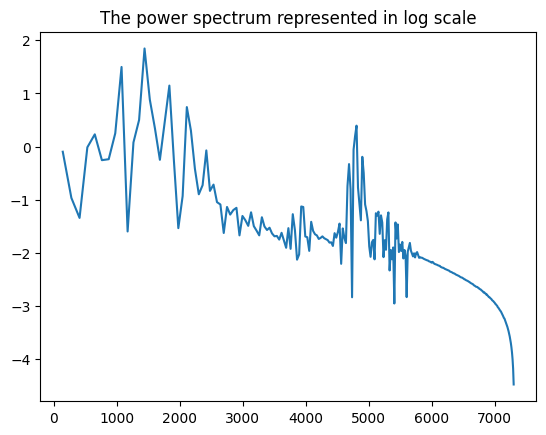

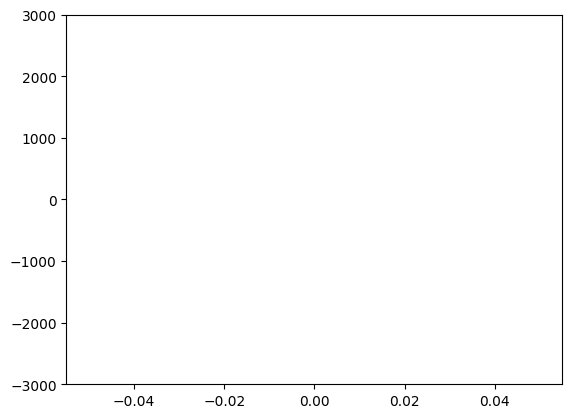

[inf nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan inf nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

In [ ]:
from scipy.fft import rfft, rfftfreq
from scipy.fftpack import dct

for index, row in df.iterrows():
  if index==10:
    file_name = row['filename']
    file_path = os.path.join(audio_dir, file_name)
y, sr = librosa.load(file_path)

def triangular_window(n,N):
  return 1-np.abs((n-N/2)/N*2)

s = 25000
wind_10ms = y[s:s+int(sr*0.025)]

N = len(wind_10ms)
yf = np.abs(rfft(wind_10ms))
x = np.linspace(0,len(yf),len(yf))
windowed_fft = triangular_window(x,len(yf))*np.abs(yf)**2
xf = rfftfreq(N, 1/sr)
log = np.log10(windowed_fft)
cosine = dct(log)**2

melscale = 2595*np.log(1+xf/700)

fig_fft= plt.figure()
ax1=fig_fft.add_subplot(111)
ax1.set_title('Frequency spectrum of a 25ms-long fragment of a recording')
ax1.plot(xf, yf)

fig_mels = plt.figure()
ax2=fig_mels.add_subplot(111)
ax2.plot(melscale, windowed_fft)
ax2.set_title('Windowed frequency spectrum represented on mel scale')
plt.show()

fig_logscale = plt.figure()
ax3=fig_logscale.add_subplot(111)
ax3.plot(melscale, log)
ax3.set_title('The power spectrum represented in log scale')
plt.show()

fig_cosine = plt.figure()
ax4=fig_cosine.add_subplot(111)
ax4.plot(melscale, cosine)
# ax4.set_xlim(1000,4000)
ax4.set_ylim(-3000,3000)
plt.show()
print(cosine)



# **How the resampling is done**